# SkimLit

> The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper  we're replicating (the source of the dataset we'll be using) is available here: https://arxiv.org/pdf/1710.06071.pdf

The model architecture that they use to achieve their best results is available here: https://arxiv.org/pdf/1612.05251.pdf



In [1]:
## Confirm access to a GPU
# !nvidia-smi -L

## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# check what files are in the Pubmed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [4]:
# start our experiments using the 20k dataset with numbers replaced with @ sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# check all of the file names in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, let's begin exploring it!

Let's write a function to read in all of the lines of a target text file.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  '''
  Reads filename (a text filename) and returns the lines of text as a list.
  
  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  '''
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines in the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Let's think about how we want our data to look...

Example: a list of dictionary....( a list of abstracts containing dictionaries for each line (sentence)).

```
[{'line_number': 0,
   'target': "BACKGROUND",
   'text': "Emotional eating is associated with overeating and the development of obesity.",
   'total_lines':11}
   ...]
```

Line number is important as sequence matters. (conclusion cannot come before introduction.)
Total lines - number of lines in a given abstract.


In [9]:
 def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  absract_lines = ""  # create an empty abstract
  abstract_samples = []  # create an empty list of abstracts
  
  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):  # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace():  # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()  # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower()  # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (starts from 0)
        abstract_samples.append(line_data)  # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled structure
        abstract_lines += line
  
  return abstract_samples

In [10]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 494 ms, sys: 125 ms, total: 619 ms
Wall time: 622 ms


In [11]:
# check the first abstract of our training data
train_samples[:13]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it.

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [14]:
# check out the distribution of labels
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

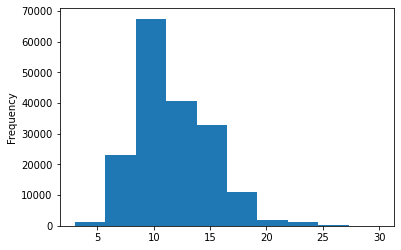

In [15]:
# let's check the length of different abstracts (number of lines in abstracts)
train_df.total_lines.plot.hist();

In [16]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

### Get lists of sentences

In [17]:
# Convert abstracts text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [18]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
# View 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models required numeric labels)

### One-hot encode labels

In [20]:
# One hto encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [21]:
# extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [22]:
# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling experiments

### Model 0: Getting a baseline

Let's start modelling with TF-IDF Multinomial Naive Bayes classifier.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [26]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [27]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

Let's use helper function for calculating other evaluation metrics (precision, recall, f1): https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [28]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import calculate_results

--2021-11-24 05:18:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-24 05:18:59 (87.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [29]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

 ### Preparing our data (the text) for deep sequence models

Our data is in text format right now. That's why we've got to create vectorization and embedding layers.

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [31]:
# How long is each sentence on average? ( to get an idea of distribution of sentence length)
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens


26.338269273494777

So, the average sentence length is 26 words (tokens).

It is important because when we create batches of tensors, Tensorflow prefers them all to be in same shape.
We calculate the average to pad the sequences to make them of same length and cut the extra large ones, such that every tensor has same dimensions. 

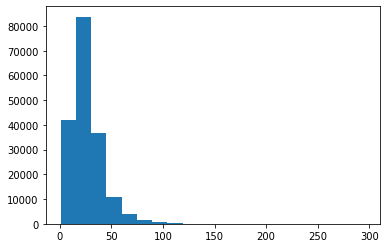

In [32]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [33]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

This implies that 95% of sentences are under 55 tokens in length.

In [34]:
# maximum sequence length in the training set
max(sent_lens)

296

In [35]:
min(sent_lens)

1

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [36]:
# How many words are in our vocab? ( taken from table 2 in paper)
max_tokens = 68000

`max_tokens` = how many words in your dataset do you want to allow text vectorizer layer to turn into numbers?

So, let's say vocab has 10000 words but we define `max_tokens` to be 5000. Then only most common 5000 words in vocab will be mapped to a number and the rest 5000 will be mapped to out of vocab token (unknown). 

In [37]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # no. of words in vocab
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences


In [38]:
# adapt text vectorizer to the training sentences
text_vectorizer.adapt(train_sentences)

In [39]:
# test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")
print(f"\nLength of vectorized text: {len(text_vectorizer([target_sentence])[0])}")

Text:
the adance -lsb- apixaban versus dual-antiplatelet therapy ( clopidogrel and aspirin ) in acute non-disabling cerebrovascular events -rsb- study is a randomized , double-blind clinical trial with a target enrollment of @,@ patients .

Length of text: 34

Vectorized text: [[    2 41414    46  3521   110 31590    66  1255     3  1271     5   229
  18285  3104   124    45    17    20     8    29   236    47    32     7
      8   492  1375     4    12     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Length of vectorized text: 55


In [40]:
 # How many words in our training vocab?
 rct_20k_text_vocab = text_vectorizer.get_vocabulary()
 print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
 print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
 print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

Text vectorizer has converted text into numbers. However, it doesn't necessarily capture relationship between those numbers. Let's use an embedding layer for that purpose.

In [42]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocab
                               output_dim=128, # diff embedding sizes result in drastically diff number of parameters to be learned
                               mask_zero=True, # use masking to handle variable sequence length
                               name="token_embedding") 

In [43]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the adance -lsb- apixaban versus dual-antiplatelet therapy ( clopidogrel and aspirin ) in acute non-disabling cerebrovascular events -rsb- study is a randomized , double-blind clinical trial with a target enrollment of @,@ patients .

Sentence after vectorization (before embedding):
 [[    2 41414    46  3521   110 31590    66  1255     3  1271     5   229
  18285  3104   124    45    17    20     8    29   236    47    32     7
      8   492  1375     4    12     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.01551728 -0.01566576  0.04928553 ...  0.02166918  0.04826404
    0.04900381]
  [ 0.01074367 -0.03356468 -0.01045381 ...  0.04921844  0.00128333
    0.04209739]
  [-0.0266318  -0.02328237 -0.02141007 ... -0.0319619  -0.04679594
   -0.00554371]
  ...
  [-0.04649762 -0.02513361  0.03357049 ... -0.01584027  0.0

## Creating datasets (making sure our daat loads as fast as possible)

We're going to setup our data to run as fast as possible with the tensorflow `tf.data` API.

Resource: 
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [44]:
# Turn our data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [45]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

We are not shuffling the data as the order of data in dataset is important for this sequence problem. We want our model to learn the sequence in our data.

### Model 1: Conv1D with token embeddings

In [48]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) #vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)  # condense the output of feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
# get the model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [50]:
len(train_dataset)  # number of batches

5627

In [52]:
# total number of samples
len(train_dataset) * 32

180064

In [54]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # we only want our model to look at 10% of batches at every epoch
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 60s 104ms/step - loss: 0.9061 - accuracy: 0.6449 - val_loss: 0.6847 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 58s 104ms/step - loss: 0.6593 - accuracy: 0.7546 - val_loss: 0.6283 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 59s 104ms/step - loss: 0.6193 - accuracy: 0.7733 - val_loss: 0.5964 - val_accuracy: 0.7856


In [55]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5984 - accuracy: 0.7861


[0.5984246730804443, 0.7861114740371704]

In [56]:
# make predictions (our model predicts prediction probailities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.2457262e-01, 1.7730136e-01, 7.7997021e-02, 2.9466859e-01,
         2.5460439e-02],
        [4.5923764e-01, 2.6290762e-01, 1.3430640e-02, 2.5610608e-01,
         8.3179791e-03],
        [1.4603783e-01, 8.3585288e-03, 1.7351055e-03, 8.4382087e-01,
         4.7709851e-05],
        ...,
        [5.9582994e-06, 8.4919337e-04, 9.0871897e-04, 4.5762054e-06,
         9.9823159e-01],
        [4.7835737e-02, 4.5832485e-01, 9.9934578e-02, 6.4856313e-02,
         3.2904851e-01],
        [1.9920105e-01, 6.5728760e-01, 4.4998743e-02, 4.3882597e-02,
         5.4630008e-02]], dtype=float32), (30212, 5))

In [57]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [59]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 78.61114788825633,
 'f1': 0.783521898873432,
 'precision': 0.7824396263126093,
 'recall': 0.7861114788825633}

In [60]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Model 2: Feature Extraction with Pretrained token embeddings

Now let's use pretrained word embeddings from Tensorflow hub: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used Glove embeddings, however we'll be using USE pretrained word embeddings from Tensorflow hub.

In [61]:
# Download pretrained Tensorflow hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         trainable=False,
                                         name="universal_sentence_encoder")

In [72]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:10]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random Sentence:
 in contrast , distribution of pain and treatment received affected associations between motion parameters and patient-rated outcomes .
Sentence after embedding:
 [ 0.05508409 -0.01292985 -0.03174994  0.04045106  0.07002206 -0.00459428
  0.00088586 -0.02688579 -0.07011919  0.0622234 ]

Length of sentence embedding: 512


### Bulding and fitting an NLP feature extraction model using pretrained embeddings Tensorflow Hub

In [78]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [79]:
# Get a summary of the model
model_2.summary()


Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [80]:
# Fit model_2 to data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9137 - accuracy: 0.6497 - val_loss: 0.7982 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7698 - accuracy: 0.7005 - val_loss: 0.7547 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7506 - accuracy: 0.7136 - val_loss: 0.7377 - val_accuracy: 0.7151


In [81]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7400 - accuracy: 0.7135


[0.7399579286575317, 0.7135244011878967]

In [82]:
# Make predcitions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.3377498e-01, 3.7362003e-01, 2.3857362e-03, 1.8113156e-01,
        9.0877125e-03],
       [3.6340296e-01, 4.8977691e-01, 3.6034859e-03, 1.4041299e-01,
        2.8037198e-03],
       [2.3557147e-01, 1.8178922e-01, 2.0815091e-02, 5.2340889e-01,
        3.8415380e-02],
       ...,
       [1.4629508e-03, 5.8199689e-03, 4.8547126e-02, 9.3338126e-04,
        9.4323653e-01],
       [4.2127105e-03, 4.9295329e-02, 1.9430697e-01, 1.4555219e-03,
        7.5072944e-01],
       [1.5316339e-01, 2.8733587e-01, 4.9652782e-01, 4.4739014e-03,
        5.8499038e-02]], dtype=float32)

In [83]:
# Convert the prediction probailities to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [84]:
# calculate model_2 results
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)

In [85]:
model_2_results

{'accuracy': 71.35244273798492,
 'f1': 0.7104807750352162,
 'precision': 0.7145763368022195,
 'recall': 0.7135244273798491}

In [86]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Model 3: Conv1D with character embeddings

#### Creating a character-level tokenizer

In [87]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [92]:
# make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'i n   c o n t r a s t   ,   d i s t r i b u t i o n   o f   p a i n   a n d   t r e a t m e n t   r e c e i v e d   a f f e c t e d   a s s o c i a t i o n s   b e t w e e n   m o t i o n   p a r a m e t e r s   a n d   p a t i e n t - r a t e d   o u t c o m e s   .'

In [93]:
# split sequence-level splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars =[split_chars(sentence) for sentence in val_sentences]
test_chars =[split_chars(sentence) for sentence in test_sentences]


In [95]:
# what's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

In [108]:
char_lens[:10]

[281, 137, 111, 65, 209, 147, 161, 164, 180, 51]

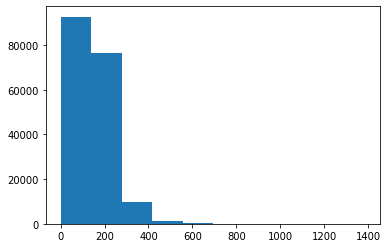

In [107]:
# check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=10);

In [110]:
# find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [111]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits +string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [118]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) +2 # add 2 for spance and OOV token (OOV = out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None,
                                    name="char_vectorizer")

In [119]:
# Adapt character vectorizer to training character 
char_vectorizer.adapt(train_chars)

In [117]:
# check character vocabs stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters; {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 57
5 most common characters; ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['|', '"', ']', '\\', '[']


In [121]:
# Test out haracter vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e   p r i m a r y   o u t c o m e   w a s   c h a n g e   i n   p l a s m a   l d l - c h o l e s t e r o l   (   l d l - c   )   .

Length of random_train_chars: 57

Vectorized chars:
 [[ 3 13  2 14  8  4 15  5  8 19  7 16  3 11  7 15  2 20  5  9 11 13  5  6
  18  2  4  6 14 12  5  9 15  5 12 10 12 11 13  7 12  2  9  3  2  8  7 12
  12 10 12 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 